# Lipstick Color Analysis and Recommendation

This notebook performs analysis and generates recommendations for lipstick products based on color characteristics and user reviews. The analysis includes:

1. Data preprocessing and cleaning
2. Color analysis and clustering

## Setup and Import Libraries

In [13]:
import warnings
import os

os.environ["MKL_DISABLE_FAST_MM"] = "1"
warnings.filterwarnings('ignore', category=UserWarning)
# warnings.filterwarnings('ignore', category=RuntimeWarning)
# warnings.filterwarnings('ignore', message='.*Intel.*')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
import base64
from PIL import Image
from io import BytesIO
from IPython.display import display, HTML
import warnings
import re
from typing import List, Dict, Tuple

# Configure display options
pd.set_option('display.max_columns', None)

np.random.seed(42)

## 1. Data Processing

In [14]:
class LipstickDataProcessor:
    """Process and analyze lipstick product data with color information."""
    
    def __init__(self, file_path: str):
        """Initialize with data file path."""
        self.df = pd.read_pickle(file_path)
        self.processed_df = None
        
    def process_urls(self) -> None:
        """Process and update product URLs."""
        def update_sku_url(row: pd.Series) -> str:
            base_url = row['targetUrl']
            updated_url = re.sub(r'skuId=\d+', f'skuId={row["skuID"]}', base_url)
            return updated_url
            
        self.df['processed_url'] = self.df.apply(update_sku_url, axis=1)
        self.df['full_url'] = 'https://www.sephora.com' + self.df['processed_url']
        self.df.drop('processed_url', axis=1, inplace=True)
        
    def clean_data(self) -> None:
        """Clean and prepare the data for analysis."""
        # Drop rows with missing skin tone
        self.df = self.df.dropna(subset=['ContextDataValues.skinTone.ValueLabel'])
        
        # Remove 'notSure' skin tone responses
        self.df = self.df[self.df['ContextDataValues.skinTone.ValueLabel'] != 'notSure']
        
        # Drop rows with invalid RGB values
        self.df = self.df[~self.df['avg_rgb'].apply(lambda x: np.array_equal(x, [0, 0, 0]))]
        self.df = self.df.dropna(subset=['avg_rgb'])
        
        # Standardize skin tone labels
        self.df['ContextDataValues.skinTone.ValueLabel'] = self.df['ContextDataValues.skinTone.ValueLabel'].replace({
            'Ebony': 'Rich',
            'Olive': 'Tan'
        })

In [15]:
# Initialize data processor and process data
processor = LipstickDataProcessor("processed_data/metadata_with_assets_feedback.pkl")
processor.process_urls()
processor.clean_data()

# Display basic information
print(f"Total number of records: {len(processor.df)}")
print(f"Number of unique products: {processor.df['productID'].nunique()}")
print(f"Number of unique SKUs: {processor.df['skuID'].nunique()}")

Total number of records: 53539
Number of unique products: 215
Number of unique SKUs: 1108


## 2. Color Analysis and Clustering

In [10]:
class ColorAnalyzer:
    """Analyze color patterns and create color clusters with cross validation."""
    
    def __init__(self, data: pd.DataFrame):
        self.data = data
        self.n_clusters = 23
        self.kmeans_model = None
        self.cluster_labels = None
        self.cv_results = None
        
    def normalize_rgb_values(self) -> None:
        """Extract and normalize RGB values from avg_rgb column."""
        self.data[['R', 'G', 'B']] = pd.DataFrame(
            self.data['avg_rgb'].tolist(), 
            index=self.data.index
        ) / 255.0
        
    def evaluate_clustering(self, X: np.ndarray, n_splits: int = 5) -> Dict:
        """
        Evaluate clustering using cross validation.
        
        Args:
            X: RGB values array
            n_splits: Number of CV splits
            
        Returns:
            Dictionary containing evaluation metrics
        """
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        metrics = {
            'silhouette_scores': [],
            'calinski_scores': [],
            'davies_scores': []
        }
        
        for train_idx, val_idx in kf.split(X):
            # Fit on training data
            kmeans = KMeans(
                n_clusters=self.n_clusters,
                random_state=42,
                n_init=10
            )
            kmeans.fit(X[train_idx])
            
            # Predict on validation data
            val_labels = kmeans.predict(X[val_idx])
            
            # Calculate metrics
            metrics['silhouette_scores'].append(
                silhouette_score(X[val_idx], val_labels)
            )
            metrics['calinski_scores'].append(
                calinski_harabasz_score(X[val_idx], val_labels)
            )
            metrics['davies_scores'].append(
                davies_bouldin_score(X[val_idx], val_labels)
            )
            
        return metrics
        
    def find_optimal_clusters(self, k_range: range = range(5, 31)) -> Dict:
        """
        Find optimal number of clusters using cross validation.
        
        Args:
            k_range: Range of k values to test (starting from 5)
            
        Returns:
            Dictionary containing evaluation results for each k
        """
        X = self.data[['R', 'G', 'B']].values
        results = {}
        
        for k in k_range:
            self.n_clusters = k
            cv_metrics = self.evaluate_clustering(X)
            
            results[k] = {
                'silhouette_mean': np.mean(cv_metrics['silhouette_scores']),
                'silhouette_std': np.std(cv_metrics['silhouette_scores']),
                'calinski_mean': np.mean(cv_metrics['calinski_scores']),
                'calinski_std': np.std(cv_metrics['calinski_scores']),
                'davies_mean': np.mean(cv_metrics['davies_scores']),
                'davies_std': np.std(cv_metrics['davies_scores'])
            }
            
        self.cv_results = results
        self._find_optimal_k()
        return results
    
    def _find_optimal_k(self) -> None:
        """Find optimal number of clusters based on combined metrics."""
        k_values = list(self.cv_results.keys())
        
        # Normalize metrics to [0,1] range for comparison
        silhouette_scores = [self.cv_results[k]['silhouette_mean'] for k in k_values]
        calinski_scores = [self.cv_results[k]['calinski_mean'] for k in k_values]
        davies_scores = [self.cv_results[k]['davies_mean'] for k in k_values]
        
        # Normalize scores
        norm_silhouette = (silhouette_scores - np.min(silhouette_scores)) / (np.max(silhouette_scores) - np.min(silhouette_scores))
        norm_calinski = (calinski_scores - np.min(calinski_scores)) / (np.max(calinski_scores) - np.min(calinski_scores))
        norm_davies = 1 - (davies_scores - np.min(davies_scores)) / (np.max(davies_scores) - np.min(davies_scores))
        
        # Combine scores
        combined_scores = (norm_silhouette + norm_calinski + norm_davies) / 3
        
        # Find optimal k
        optimal_idx = np.argmax(combined_scores)
        self.optimal_k = k_values[optimal_idx]
        
        print("\nOptimal number of clusters analysis:")
        print(f"Based on combined metrics, optimal k = {self.optimal_k}")
        print("\nMetric values at optimal k:")
        print(f"Silhouette Score: {self.cv_results[self.optimal_k]['silhouette_mean']:.3f} ± {self.cv_results[self.optimal_k]['silhouette_std']:.3f}")
        print(f"Calinski-Harabasz Score: {self.cv_results[self.optimal_k]['calinski_mean']:.3f} ± {self.cv_results[self.optimal_k]['calinski_std']:.3f}")
        print(f"Davies-Bouldin Score: {self.cv_results[self.optimal_k]['davies_mean']:.3f} ± {self.cv_results[self.optimal_k]['davies_std']:.3f}")
    
    def plot_cv_results(self) -> None:
        """Plot cross validation results."""
        if self.cv_results is None:
            raise ValueError("Run find_optimal_clusters first")
            
        k_values = list(self.cv_results.keys())
        
        # Set style
        # plt.style.use('seaborn')
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))
        fig.suptitle('Clustering Evaluation Metrics', fontsize=16, y=1.05)
        
        # Color scheme
        main_color = '#2E86C1'
        error_color = '#AED6F1'
        
        # Common plotting parameters
        common_params = {
            'marker': 'o',
            'markersize': 6,
            'linewidth': 2,
            'elinewidth': 1,
            'capsize': 3,
            'color': main_color,
            'ecolor': error_color
        }
        
        # Plot metrics
        metrics = [
            ('silhouette_mean', 'Silhouette Score\n(higher is better)'),
            ('calinski_mean', 'Calinski-Harabasz Score\n(higher is better)'),
            ('davies_mean', 'Davies-Bouldin Score\n(lower is better)')
        ]
        
        for idx, (metric, title) in enumerate(metrics):
            axes[idx].errorbar(
                k_values,
                [self.cv_results[k][metric] for k in k_values],
                yerr=[self.cv_results[k][f"{metric.split('_')[0]}_std"] for k in k_values],
                **common_params
            )
            
            # Add optimal k vertical line
            axes[idx].axvline(x=self.optimal_k, color='red', linestyle='--', alpha=0.5)
            
            # Style subplot
            axes[idx].set_title(title, fontsize=12, pad=15)
            axes[idx].set_xlabel('Number of Clusters (k)', fontsize=10)
            axes[idx].grid(True, linestyle='--', alpha=0.7)
            axes[idx].tick_params(labelsize=9)
            axes[idx].set_facecolor('#F8F9F9')
            
            # Add optimal k annotation
            axes[idx].annotate(f'Optimal k={self.optimal_k}', 
                             xy=(self.optimal_k, axes[idx].get_ylim()[1]),
                             xytext=(10, 10), textcoords='offset points',
                             ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

In [17]:
# Initialize analyzer
analyzer = ColorAnalyzer(processor.df)
analyzer.normalize_rgb_values()

# Find optimal number of clusters (now starting from k=5)
results = analyzer.find_optimal_clusters(range(5, 31))

In [21]:
def save_analyzer(analyzer, file_path: str = 'trained_models/sephora_lipstick_clustering_model.pkl') -> None:
    with open(file_path, 'wb') as f:
        pickle.dump(analyzer, f)
def load_analyzer(file_path: str = 'trained_models/sephora_lipstick_clustering_model.pkl') -> ColorAnalyzer:
    with open(file_path, 'rb') as f:
        return pickle.load(f)

save_analyzer(analyzer, 'trained_models/sephora_lipstick_clustering_model.pkl')

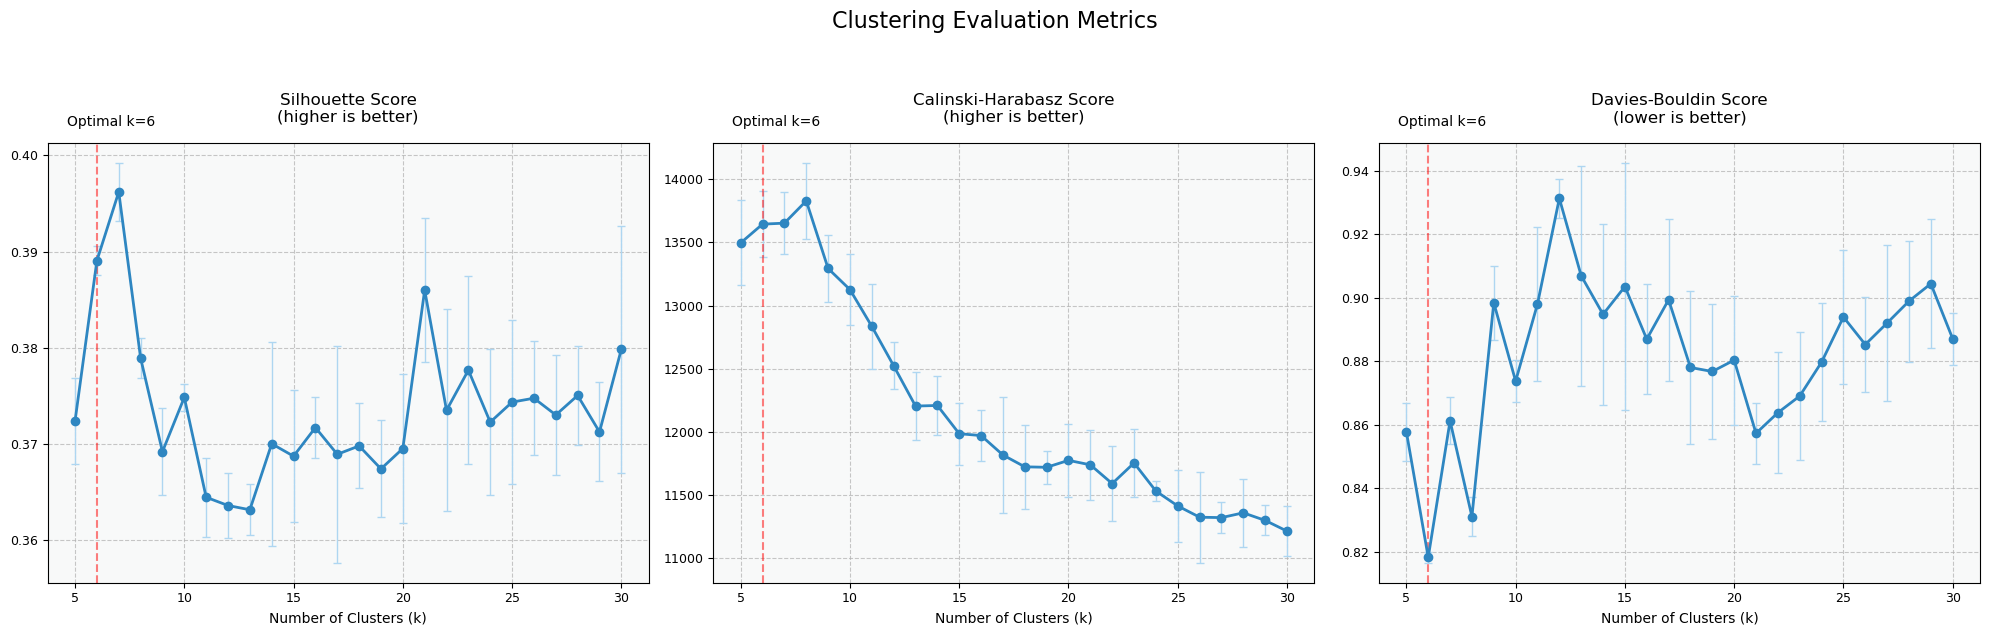

In [22]:
# Plot results with improved visualization
analyzer = load_analyzer('trained_models/sephora_lipstick_clustering_model.pkl')

analyzer.plot_cv_results()